In [187]:
import json
import logging
from typing import List, Tuple

import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem import Draw
from rdkit.Chem.rdChemReactions import ReactionFromSmarts

from syndirella.SMARTSHandler import SMARTSHandler
from syndirella.route.Reaction import Reaction

logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# Set the logging level for the PIL library to WARNING to suppress DEBUG logs
pil_logger = logging.getLogger('PIL')
pil_logger.setLevel(logging.WARNING)
# Suppress RDKit errors
RDLogger.DisableLog('rdApp.error')

path = '../../../syndirella/constants/RXN_SMIRKS_CONSTANTS.json'
with open(path, 'r') as file:
    smirks = json.load(file)

## Goal: Add `Alpha_alkylation_of_ester/amide` as an additional reaction option to `Alpha_alkylation_of_ester/amide_alcohol`

Clean up SMIRKS.

In [188]:
# we already have a partially filled in option
{
    "name": "Alpha_alkylation_of_ester/amide",
    "replace_with": "Alpha_alkylation_of_ester/amide_alcohol",
    "reactant_smarts_to_replace": "[c:1]-[C:2]-[Cl,Br]",
    "reactant_id_to_replace": "Kate please fill this",
    "reactant_smarts_to_replace_with": "[c:1]-[C:2]-[OH]",
    "replacement_connecting_atom_id": "Kate please fill this"
}

{'name': 'Alpha_alkylation_of_ester/amide',
 'replace_with': 'Alpha_alkylation_of_ester/amide_alcohol',
 'reactant_smarts_to_replace': '[c:1]-[C:2]-[Cl,Br]',
 'reactant_id_to_replace': 'Kate please fill this',
 'reactant_smarts_to_replace_with': '[c:1]-[C:2]-[OH]',
 'replacement_connecting_atom_id': 'Kate please fill this'}

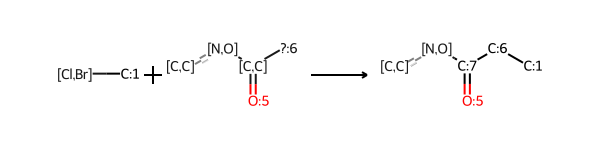

In [189]:
# first need to correct the current "Alpha_alkylation_of_ester/amide"
aa = smirks['Alpha_alkylation_of_ester/amide']
aa = ReactionFromSmarts(aa)
aa

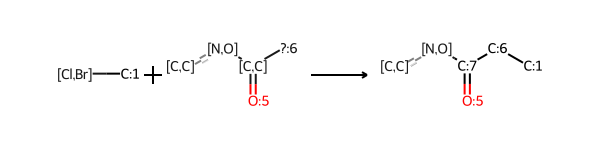

In [190]:
# this is not quite right, need to add extra carbon atom, I did this with SMARTSPlus
aa_fix = "[C;R0:1]-[Cl,Br].[c,C:3][N,O:4]-[c,C:7](=[O:5])-[c,C;R0:6]>>[C:1]-[C:6]-[c:7](=[O:5])-[N,O:4][c,C:3]"
aa_fix = ReactionFromSmarts(aa_fix)
aa_fix

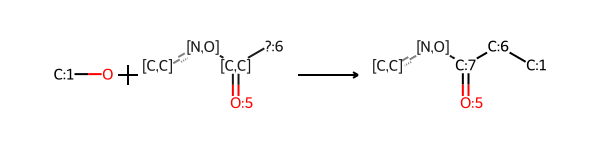

In [191]:
# need to correct the current "Alpha_alkylation_of_ester/amide_alcohol"
aaa = smirks['Alpha_alkylation_of_ester/amide_alcohol']
aaarxn = ReactionFromSmarts(aaa)
aaarxn

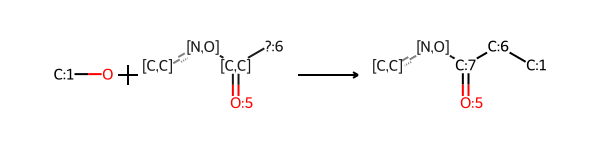

In [192]:
# this is not quite right, need to add extra carbon atom, I did this with SMARTSPlus
aaa_fix = "[C;R0:1]-[O&H1].[c,C:3][N,O:4]-[c,C:7](=[O:5])-[c,C;R0:6]>>[C:1]-[C:6]-[C:7](=[O:5])-[N,O:4][c,C:3]"
aaa_fixrxn = ReactionFromSmarts(aaa_fix)
aaa_fixrxn

In [193]:
# update rxn smirks file

# write new RXN_SMIRKS_CONSTANTS.json
path = '../../../syndirella/constants/RXN_SMIRKS_CONSTANTS.json'
with open(path, 'r') as file:
    smirks = json.load(file)

smirks[
    'Alpha_alkylation_of_ester/amide'] = "[C;R0:1]-[Cl,Br].[c,C:3][N,O:4]-[c,C:7](=[O:5])-[c,C;R0:6]>>[C:1]-[C:6]-[c:7](=[O:5])-[N,O:4][c,C:3]"
smirks[
    'Alpha_alkylation_of_ester/amide_alcohol'] = "[C;R0:1]-[O&H1].[c,C:3][N,O:4]-[c,C:7](=[O:5])-[c,C;R0:6]>>[C:1]-[C:6]-[C:7](=[O:5])-[N,O:4][c,C:3]"

with open(path, 'w') as file:
    json.dump(smirks, file, indent=4)

Test additional reaction on examples.

In [194]:
df = pd.read_csv('../fairydust_example_data/Alpha_alkylation_of_ester:amide_examples.csv')
df

smiles      1_r1_smiles 1_r2_smiles   
0  COC(=O)C(C)C(C)=O   COC(=O)CC(C)=O         CBr  \
1         CCCC(=O)NC         CNC(C)=O        CCCl   
2  CCCC(=O)NC1CCCCC1  CC(=O)NC1CCCCC1        CCCl   

                        1_reaction  
0  Alpha_alkylation_of_ester/amide  
1  Alpha_alkylation_of_ester/amide  
2  Alpha_alkylation_of_ester/amide

Alpha_alkylation_of_ester:amide_examples


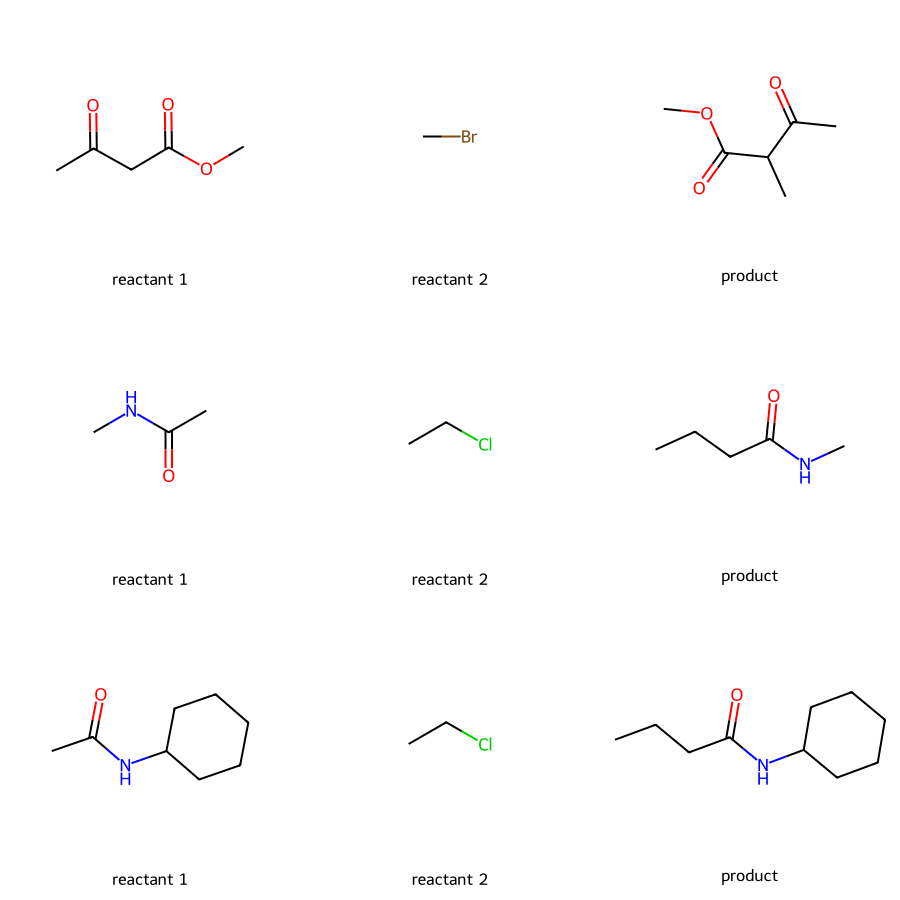

In [195]:
# display the reaction
mols = []
legend = []
for i, row in df.iterrows():
    mols.append(Chem.MolFromSmiles(row['1_r1_smiles']))
    mols.append(Chem.MolFromSmiles(row['1_r2_smiles']))
    mols.append(Chem.MolFromSmiles(row['smiles']))
    legend.extend(['reactant 1', 'reactant 2', 'product'])
print('Alpha_alkylation_of_ester:amide_examples')
Draw.MolsToGridImage(mols, legends=legend, molsPerRow=3, subImgSize=(300, 300))

In [196]:
# do a smarts match on the first example
r1 = Chem.MolFromSmiles(df['1_r1_smiles'][0])
r2 = Chem.MolFromSmiles(df['1_r2_smiles'][0])
product = Chem.MolFromSmiles(df['smiles'][0])
matches = r1.GetSubstructMatches(Chem.MolFromSmarts('[c,C:3][N,O:4]-[c,C:7](=[O:5])-[c,C;R0:6]'))
matches

((0, 1, 2, 3, 4),)

In [197]:
matches = r2.GetSubstructMatches(Chem.MolFromSmarts('[C;R0:1]-[Cl,Br]'))
matches

((0, 1),)

Reactant atoms to replace:


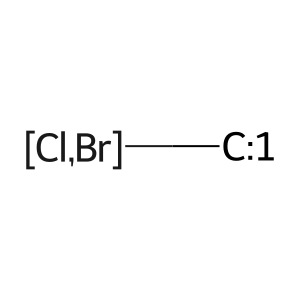

New reactant atoms to add:


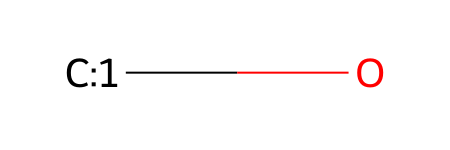

In [198]:
# new configuration done manually
new_config = [{
    "name": "Alpha_alkylation_of_ester/amide",
    "replace_with": "Alpha_alkylation_of_ester/amide_alcohol",
    "reactant_smarts_to_replace": "[C;R0:1]-[Cl,Br]",  # changed to not work on carbons in rings
    "reactant_id_to_replace": 1,
    "reactant_smarts_to_replace_with": "[C;R0:1]-[OH]",  # changed to not work on carbons in rings
    "replacement_connecting_atom_id": 0
}]

# can also view at [https://smarts.plus/smartsview](https://smarts.plus/smartsview)
img = Draw.MolToImage(Chem.MolFromSmarts(new_config[0]['reactant_smarts_to_replace']))
print("Reactant atoms to replace:")
display(img)
print("New reactant atoms to add:")
Chem.MolFromSmarts(new_config[0]['reactant_smarts_to_replace_with'])

In [199]:
# Testing
rxn_smirks = json.load(open('../../../syndirella/constants/RXN_SMIRKS_CONSTANTS.json'))

reaction_name: str = 'Alpha_alkylation_of_ester/amide'
to_replace_with: str = 'Alpha_alkylation_of_ester/amide_alcohol'

smarts_handler: SMARTSHandler = SMARTSHandler()
route_uuid: str = '1235'
logger = logging.getLogger('Test')
smirks = rxn_smirks[to_replace_with]

for i in range(0, len(df)):
    product: Chem.Mol = Chem.MolFromSmiles(df['smiles'][i])
    reactants: List[Chem.Mol] = [Chem.MolFromSmiles(df['1_r1_smiles'][i]), Chem.MolFromSmiles(df['1_r2_smiles'][i])]
    rxn = Reaction(product=product, reactants=reactants, reaction_name=reaction_name, smarts_handler=smarts_handler,
                   route_uuid=route_uuid)
    rxn.logger = logger
    rxn.alt_reactions = new_config
    new_reaction: List[Tuple[str, Tuple[
        str, str]]] = rxn.get_additional_reactions()  # returns a list of tuples with the reaction name and reactants

    if len(new_reaction) == 0:
        print(f'No additional reactions found for example {i}')
        continue

    r1 = Chem.MolFromSmiles(new_reaction[0][1][0])
    r2 = Chem.MolFromSmiles(new_reaction[0][1][1])
    reaction: Chem.rdChemReactions = ReactionFromSmarts(smirks)
    new_reactant_combo: Tuple[Chem.Mol] = (r1, r2)
    products: Tuple[Chem.Mol] = reaction.RunReactants(new_reactant_combo)
    pred_prod = products[0][0]
    expected_inchi = Chem.MolToInchiKey(product)
    pred_inchi = Chem.MolToInchiKey(pred_prod)
    print(f'Expected Inchi: {expected_inchi}')
    print(f'Predicted Inchi: {pred_inchi}')
    print(f'Inchi Match: {expected_inchi == pred_inchi}')

2025-03-03 11:08:07,711 - Test - INFO - Additional reaction Alpha_alkylation_of_ester/amide_alcohol found for Alpha_alkylation_of_ester/amide.
2025-03-03 11:08:07,712 - Test - INFO - to_replace_with_smarts: [C;R0:1]-[OH]
2025-03-03 11:08:07,712 - Test - INFO - Found 1 new reactants.
2025-03-03 11:08:07,712 - Test - INFO - Checking new reactant O[CH3:1] for reaction Alpha_alkylation_of_ester/amide...
2025-03-03 11:08:07,712 - Test - DEBUG - Replaced reactant smiles: O[CH3:1]
2025-03-03 11:08:07,713 - Test - DEBUG - Matched atoms: (1, 0)
2025-03-03 11:08:07,713 - Test - INFO - New reactant for reaction Alpha_alkylation_of_ester/amide found.
2025-03-03 11:08:07,713 - Test - INFO - Additional reaction Alpha_alkylation_of_ester/amide_alcohol for Alpha_alkylation_of_ester/amide found and validated.
2025-03-03 11:08:07,715 - Test - INFO - Additional reaction Alpha_alkylation_of_ester/amide_alcohol found for Alpha_alkylation_of_ester/amide.
2025-03-03 11:08:07,715 - Test - INFO - to_replace_wi

Expected Inchi: NDTWZHURUDSPQV-UHFFFAOYSA-N
Predicted Inchi: NDTWZHURUDSPQV-UHFFFAOYSA-N
Inchi Match: True
Expected Inchi: OLLZXQIFCRIRMH-UHFFFAOYSA-N
Predicted Inchi: OLLZXQIFCRIRMH-UHFFFAOYSA-N
Inchi Match: True
Expected Inchi: MIUPVUSAABKKQX-UHFFFAOYSA-N
Predicted Inchi: MIUPVUSAABKKQX-UHFFFAOYSA-N
Inchi Match: True


In [200]:
# write new ADDITIONAL_RXN_OPTIONS.json
path = '../../../syndirella/constants/ADDITIONAL_RXN_OPTIONS.json'
with open(path, 'r') as file:
    additional_rxn_options = json.load(file)
# check if entry already exists
entry_exists = False
for entry in additional_rxn_options:
    # check if all values are the same
    if all([entry[key] == new_config[0][key] for key in new_config[0].keys()]):
        entry_exists = True
        print(f"Entry with name {new_config[0]['name']} and all same values already exists.")
        break

# add new entry if it doesn't exist
if not entry_exists:
    additional_rxn_options.extend(new_config)
    print(f"Added new entry with name {new_config[0]['name']} to ADDITIONAL_RXN_OPTIONS.json")
    # save
    with open(path, 'w') as file:
        json.dump(additional_rxn_options, file, indent=4)


Entry with name Alpha_alkylation_of_ester/amide and all same values already exists.
